# Exploration with Linear Triangular, Cubic Triangular, and Radial Basis

In [3]:
import numpy as np
from scipy.interpolate import Rbf, LinearNDInterpolator, CloughTocher2DInterpolator
from photutils.utils import ShepardIDWInterpolator
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

In [4]:
# synthetic example
def f(x, y):
    return -np.exp(-(y-np.sin(x))**2)

In [5]:
# create ground truth grid
x = np.linspace(-3, 3, 500)
y = np.linspace(-3, 3, 500)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

In [6]:
# 3D scatter plot

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X, Y, zs=Z)
# plt.show()

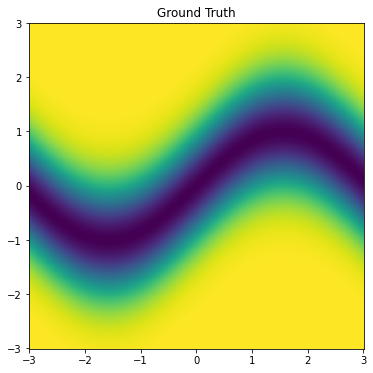

In [7]:
# color mesh map for ground truth
plt.figure(figsize=(6,6))
plt.pcolormesh(X, Y, Z, shading='auto')
plt.title('Ground Truth')
plt.show()

In [8]:
# helper function to map [0,1] to [-3,3]
def map_to_interval(vec):
    return np.subtract(np.multiply(vec, 6), 3)

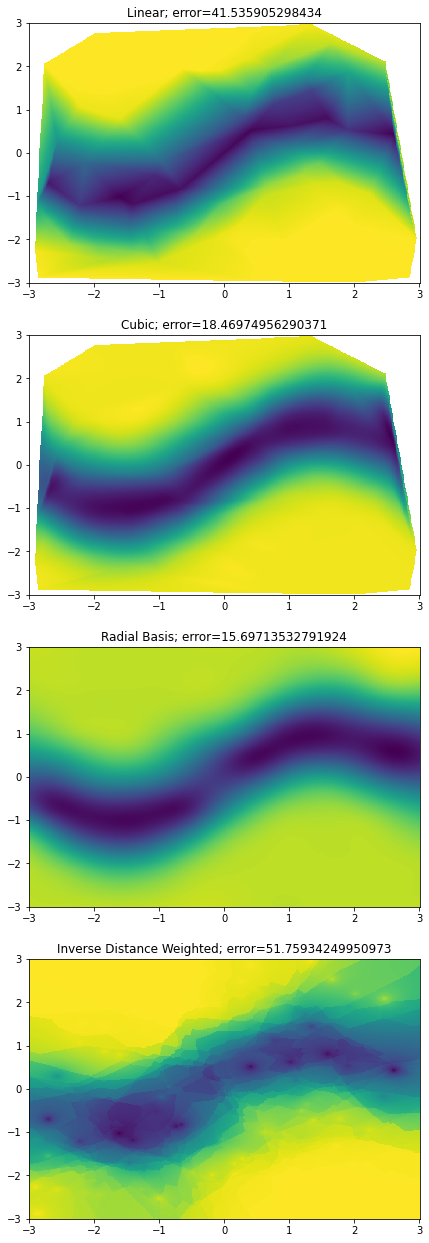

In [9]:
# sample x,y,z points
sample_x = np.random.rand(100)
sample_y = np.random.rand(100)
sample_x = map_to_interval(sample_x)
sample_y = map_to_interval(sample_y)
sample_z = f(sample_x, sample_y)

# interpolate with 3 different techniques
interp1 = LinearNDInterpolator(list(zip(sample_x, sample_y)), sample_z)
interp2 = CloughTocher2DInterpolator(list(zip(sample_x, sample_y)), sample_z)
interp3 = Rbf(sample_x, sample_y, sample_z)
interp4 = ShepardIDWInterpolator(list(zip(sample_x, sample_y)), sample_z)
Zhat1 = interp1(X, Y)
Zhat2 = interp2(X, Y)
Zhat3 = interp3(X, Y)
Zhat4 = np.zeros(X.shape)
# these loops take a second to run - not sure if there is a faster way to do this
for j in range(X.shape[0]): 
    for i in range(X.shape[1]):
        Zhat4[j,i] = interp4([X[j,i],Y[j,i]])

# ensure that the values to cut out (NaN values) are the same across linear and cubic interpolators
assert np.linalg.norm(np.isnan(Zhat1)^np.isnan(Zhat2)) == 0

# compute error
domain = np.logical_not(np.isnan(Zhat1))
Ztest1 = Zhat1[domain]
Ztest2 = Zhat2[domain]
Ztest3 = Zhat3[domain]
Ztest4 = Zhat4[domain]
Zcut = Z[domain]
err1 = np.linalg.norm(np.abs(np.subtract(Ztest1, Zcut)))
err2 = np.linalg.norm(np.abs(np.subtract(Ztest2, Zcut)))
err3 = np.linalg.norm(np.abs(np.subtract(Ztest3, Zcut)))
err4 = np.linalg.norm(np.abs(np.subtract(Ztest4, Zcut)))

# plot
fig, ax = plt.subplots(nrows=4, figsize=(7,22))
ax[0].pcolormesh(X, Y, Zhat1, shading='auto')
ax[0].set_title(f'Linear; error={err1}')
ax[1].pcolormesh(X, Y, Zhat2, shading='auto')
ax[1].set_title(f'Cubic; error={err2}')
ax[2].pcolormesh(X, Y, Zhat3, shading='auto')
ax[2].set_title(f'Radial Basis; error={err3}')
ax[3].pcolormesh(X, Y, Zhat4, shading='auto')
ax[3].set_title(f'Inverse Distance Weighted; error={err4}')
plt.show()

#### Generic function for what's above

In [16]:
def accuracy_and_cost(method, n=1000, seed=0):
    methods = [LinearNDInterpolator, CloughTocher2DInterpolator, Rbf, ShepardIDWInterpolator]
    assert method in methods
    errs = []
    costs = []
    for num in range(3,n+1): # measure for 3 to n data points
        np.random.seed(seed)
        sample_x = np.random.rand(num)
        sample_y = np.random.rand(num)
        sample_x = map_to_interval(sample_x)
        sample_y = map_to_interval(sample_y)
        sample_z = f(sample_x, sample_y)
        t0 = time.time()
        if method == Rbf:
            interp = method(sample_x, sample_y, sample_z)
        else:
            interp = method(list(zip(sample_x, sample_y)), sample_z)
        if method == ShepardIDWInterpolator:
            Zhat = np.zeros(X.shape)
            for j in range(X.shape[0]): 
                for i in range(X.shape[1]):
                    Zhat4[j,i] = interp4([X[j,i],Y[j,i]])
        else:
            Zhat = interp(X, Y)
        t1 = time.time()
        domain = np.logical_not(np.isnan(Zhat)) # this is going to measure extrapolated values for methods that extrapolate
        Zhat = Zhat[domain]
        Zcut = Z[domain]
        err = np.linalg.norm(np.abs(np.subtract(Zhat, Zcut)))
        errs.append(err)
        costs.append(t1-t0)
    return errs, costs

In [20]:
errs1, costs1 = accuracy_and_cost(LinearNDInterpolator, n=100)
errs2, costs2 = accuracy_and_cost(CloughTocher2DInterpolator, n=100)
errs3, costs3 = accuracy_and_cost(Rbf, n=100)
errs4, costs4 = accuracy_and_cost(ShepardIDWInterpolator, n=100)

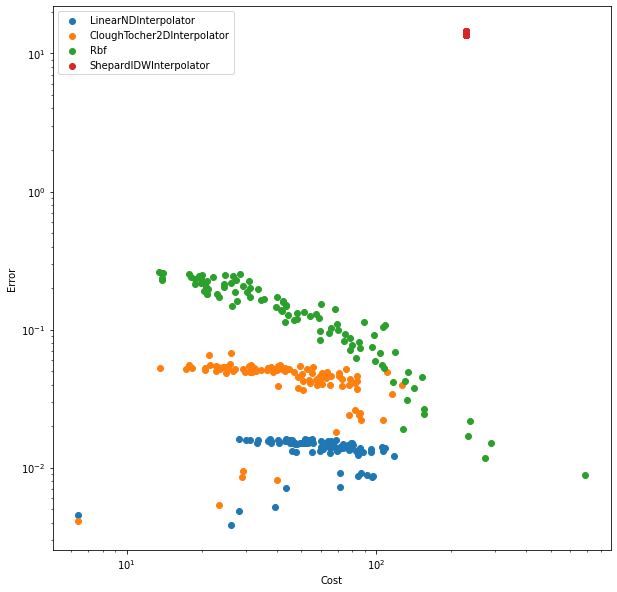

In [26]:
plt.figure(figsize=(10,10))
plt.yscale('log')
plt.xscale('log')
plt.scatter(errs1, costs1, label='LinearNDInterpolator')
plt.scatter(errs2, costs2, label='CloughTocher2DInterpolator')
plt.scatter(errs3, costs3, label='Rbf')
plt.scatter(errs4, costs4, label='ShepardIDWInterpolator')
plt.xlabel('Cost')
plt.ylabel('Error')
plt.legend()
plt.show()